### Network Analysis Demo using Email Data 

- Network Analytics
  - Graphs are a way to represent relationships between entities
  - Nodes represent entities
  - Edges represent relationships between entities
  - NetworkX is a python package for creating, manipulating, and studying the structure, dynamics, and functions of complex networks

- 2 kinda of graphs 
    - A homogenous, undirected graph
    - A heterogeneous, directed multigraph

- key concepts
  - Homogenous = 1 type of node
  - Heterogeneous = multiple types of nodes and/or edges
  - Undirected = Edges have no direction
  - Directed = Edges have a direction
      - DiGraph class provides additional methods and properties specific to directed edges, e.g., DiGraph.out_edges, DiGraph.in_degree, DiGraph.predecessors(), DiGraph.successors() etc. To allow algorithms to work with both classes easily,

- the directed versions of neighbors is equivalent to successors while DiGraph.degree reports the sum of DiGraph.in_degree and DiGraph.out_degree 

- Multi-graph = Two nodes can have multiple edges between them (TRY TO AVOID THIS)

- What to specify as nodes and edges
  - Nodes = can hashable objects (e.g. strings, numbers, files, functions, etc.) except None
  - Edges = can be any object with a length of 2 (e.g. a 2-tuple, an edge object with a 'source' and 'target' attribute, etc.)
              - can also have edge attributes (e.g. weight, time, distance, etc.)
              - an edge can be associated with any object x using G.add_edge(n1, n2, object=x).


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import networkx as nx
import matplotlib.pyplot as plt 

### Generate Fake Data


In [2]:
# Generate Date column
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 5, 31)
date_range = end_date - start_date
dates = [start_date + timedelta(days=random.randint(0, date_range.days)) for _ in range(10000)]

# Generate Categorical columns
first_names = ['John', 'Jane', 'Michael', 'Emily', 'David']
last_names = ['Smith', 'Johnson', 'Williams', 'Jones', 'Brown']
domains = ['wellsfargo.com', 'gmail.com', 'yahoo.com']
job_titles = ['Financial Analyst', 'Account Manager', 'Marketing Specialist', 'Auditor', 'Data Scientist']
lobs = ['Accounting', 'Advanced Analytics', 'Audit', 'Finance', 'Marketing']

sent_from = [f"{random.choice(first_names)}_{random.choice(last_names)}@{random.choice(domains)}" for _ in range(10000)]
sent_from_job_title = [random.choice(job_titles) if 'wellsfargo' in email else 'external' for email in sent_from]
sent_from_lob = [random.choice(lobs) if job_title else '' for job_title in sent_from_job_title]
subject = [f"Subject_{i}" for i in range(10000)]
sent_to = [f"{random.choice(first_names)}_{random.choice(last_names)}@{random.choice(domains)}" for _ in range(10000)]
sent_to_job_title = [random.choice(lobs) if 'wellsfargo' in email and random.random() < 0.8 else 'external' for email in sent_to]
sent_to_lob = [random.choice(lobs) if job_title else 'External' for job_title in sent_to_job_title]
directionality = [random.choice(['incoming', 'outgoing']) for _ in range(10000)]

# Generate Continuous column
cool_weight = np.random.normal(loc=500, scale=250, size=10000)
cool_weight = np.clip(cool_weight, 1, 1000)

# Create DataFrame
data = {
    'Date': dates,
    'SentFrom': sent_from,
    'SentFrom_JobTitle': sent_from_job_title,
    'SentFrom_LOB': sent_from_lob,
    'Subject': subject,
    'SentTo': sent_to,
    'SentTo_JobTitle': sent_to_job_title,
    'SentTo_LOB': sent_to_lob,
    'Directionality': directionality,
    'Cool_weight': cool_weight
}

df = pd.DataFrame(data)
df[['Date','SentFrom','SentTo','Directionality']].sort_values(by='Date',ascending=True).head(10)


Date                         SentFrom                      SentTo  \
6297 2024-03-01        John_Jones@wellsfargo.com     David_Johnson@gmail.com   
4238 2024-03-01            David_Jones@yahoo.com  Emily_Jones@wellsfargo.com   
3071 2024-03-01  Michael_Williams@wellsfargo.com        John_Jones@gmail.com   
2018 2024-03-01      Jane_Johnson@wellsfargo.com     Jane_Williams@yahoo.com   
5094 2024-03-01       David_Brown@wellsfargo.com   Michael_Johnson@yahoo.com   
2027 2024-03-01          John_Williams@gmail.com       Emily_Jones@yahoo.com   
921  2024-03-01     John_Williams@wellsfargo.com        Jane_Brown@gmail.com   
7509 2024-03-01       David_Brown@wellsfargo.com     Michael_Smith@yahoo.com   
5937 2024-03-01          Jane_Williams@gmail.com      Jane_Johnson@gmail.com   
7476 2024-03-01      Jane_Johnson@wellsfargo.com        Jane_Jones@yahoo.com   

     Directionality  
6297       incoming  
4238       outgoing  
3071       outgoing  
2018       outgoing  
5094       incoming  
2027       outgoing  
921        incoming  
7509       outgoing  
5937       incoming  
7476       incoming

### Create networkx graph data structure from pandas datafraome 

In [3]:
# Create a graph object 
# multidigraph -> directed graph with self loops and parallel edges
graph = nx.from_pandas_edgelist(df
                                , source='SentFrom'
                                , target='SentTo'
                                , edge_attr=['Cool_weight','Directionality']
                                #, create_using=nx.MultiDiGraph() #this should be set based on the type of network you want to create
                                )

#Info about the graph object
print(f"total nodes:{graph.number_of_nodes()}")
print(f"total edges:{graph.number_of_edges()}")
print(f"The avg on avg , a node is connected to {int(np.mean([d for _,d in graph.degree()]))} other nodes (also known as neighbors of the node")

total nodes:75
total edges:2757
The avg on avg , a node is connected to 73 other nodes (also known as neighbors of the node


### Graph Metrics 
- **diameter** *(nx.diameter)*: the longest of the shortest-paths that connect any node to another node in the Graph 
- **average** *(nx.average_shortest_path_length)*: the average number of edges to be traversed to get from one node to another in a network 

*Note: both average and diameter requrie computing theshortest path between every pair of nodes in the network, which is very expensive!*

In [4]:
#compute shortest path length for all pairs of nodes in network 
#returns a dict-of-dict that maps a node u to all other nodes in the network,
# where the inner-most mapping returns the length of the shortest path between 
# the two nodes. In other words, shortest_path_lengths[u][v] will return the 
# shortest path length between any two pair of nodes u and v:

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(graph))

In [5]:
# Length of shortest path between nodes john and jane 
shortest_path_lengths['John_Williams@yahoo.com']['Jane_Smith@wellsfargo.com']  

1

In [6]:
# This is equivalent to `diameter = nx.diameter(G), but much more efficient since we're
# reusing the pre-computed shortest path lengths!
diameter = max(nx.eccentricity(graph, sp=shortest_path_lengths).values())

print(f"In order to connect from one node to any other one we would have to traverse {diameter} edges or fewer.")

In order to connect from one node to any other one we would have to traverse 2 edges or fewer.


In [7]:
# Calculate the average path length. 
# Again, we could use nx.average_shortest_path_length to compute this directly
# but it’s much more efficient to use the shortest_path_length that we’ve already 
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

print(f"This represents the average of the shortest path length for all pairs of nodes: \n in order to reach from one node to another node, roughly {np.mean(average_path_lengths)} edges \n will be traversed on average.")

This represents the average of the shortest path length for all pairs of nodes: 
 in order to reach from one node to another node, roughly 1.0151111111111113 edges 
 will be traversed on average.


### Evaluating graph distributional Characteristics

Text(0, 0.5, 'Frequency (%)')

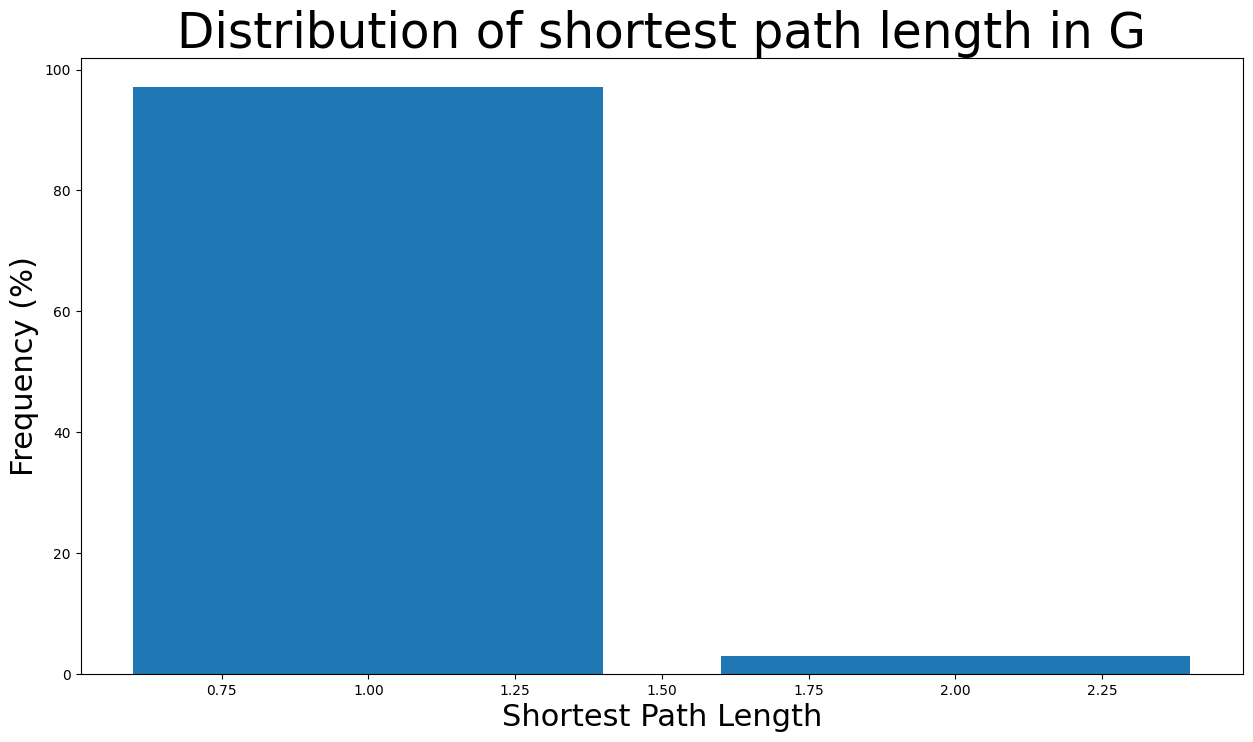

In [8]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

In [9]:
#graph density 
#<1: sparse
nx.density(graph)

#the network consists of one giant component
nx.number_connected_components(graph)

1

### Centrality Analysis
**Degree centrality** assigns an importance score based simply on the number of links held by each node. In this analysis, that means that the higher the degree centrality of a node is, the more edges are connected to the particular node and thus the more neighbor nodes (facebook friends) this node has. In fact, the degree of centrality of a node is the fraction of nodes it is connected to. In other words, it is the percentage of the network that the particular node is connected to meaning being friends with. 

In [10]:
#find nodes with highest degree centraliites
# save results in a variable to use again
degree_centrality = nx.centrality.degree_centrality(graph)  

#save the topn most connected individuals for plotting!
most_connected = [t[0] for t in (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]]

#top n most connected individuals in the network 
# NOTE: This indicates each of these individuals is somehow connected to >100% of all individuals that sent emails!
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('Michael_Williams@yahoo.com', 1.0270270270270272),
 ('Jane_Smith@wellsfargo.com', 1.0270270270270272),
 ('John_Brown@gmail.com', 1.0270270270270272),
 ('David_Smith@gmail.com', 1.0270270270270272),
 ('John_Brown@yahoo.com', 1.0270270270270272),
 ('Jane_Brown@yahoo.com', 1.0270270270270272),
 ('Michael_Brown@wellsfargo.com', 1.0270270270270272),
 ('Michael_Brown@gmail.com', 1.0270270270270272)]

In [11]:
#Number of neighbors for the nodes with the highest degree centralities 
(sorted(graph.degree, key=lambda item: item[1], reverse=True))[:8]

[('Michael_Williams@yahoo.com', 76),
 ('Jane_Smith@wellsfargo.com', 76),
 ('John_Brown@gmail.com', 76),
 ('David_Smith@gmail.com', 76),
 ('John_Brown@yahoo.com', 76),
 ('Jane_Brown@yahoo.com', 76),
 ('Michael_Brown@wellsfargo.com', 76),
 ('Michael_Brown@gmail.com', 76)]

Text(0, 0.5, 'Counts')

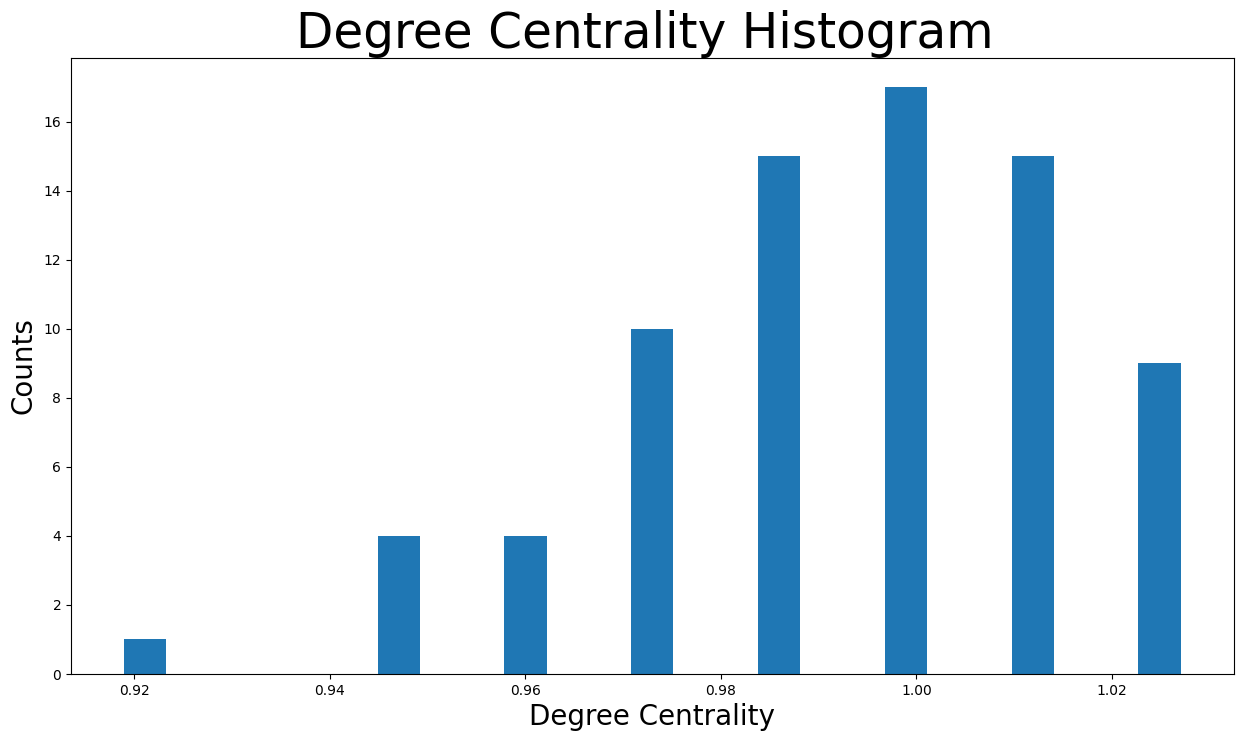

In [12]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
#plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1652346683947241,
 1.2057462807071908,
 -1.1504103746601222,
 1.2219056405431155)

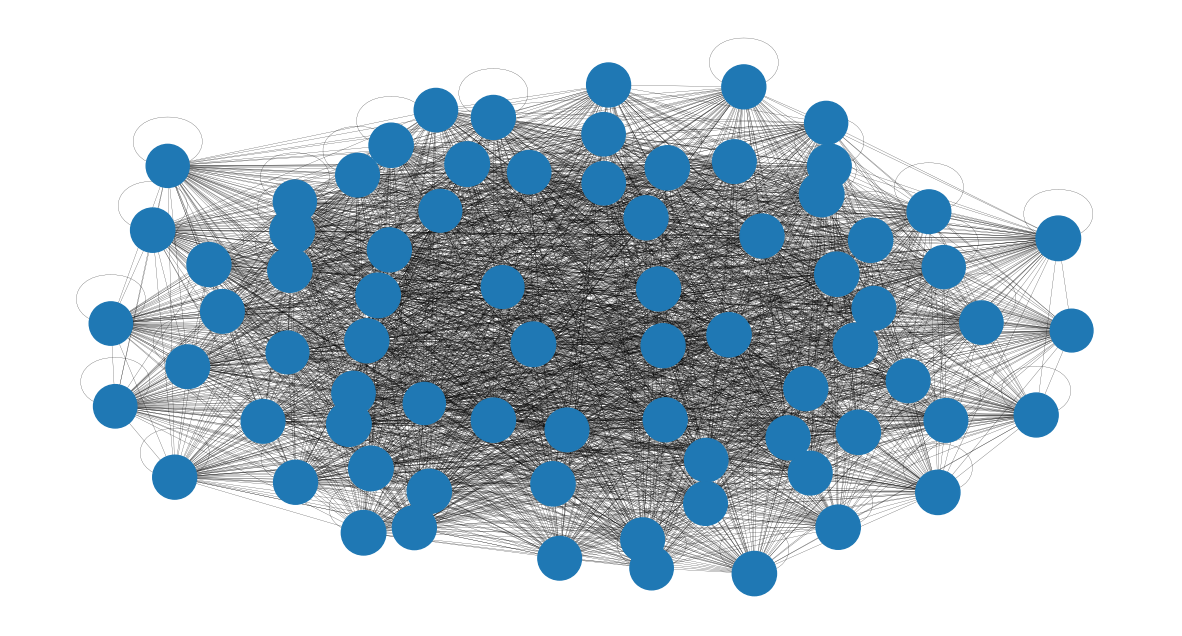

In [13]:
#Now let’s check the users with highest degree centralities from the size of their nodes:
pos = nx.spring_layout(graph, iterations=15, seed=1721)
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Betweenness Centrality (who helps spread info across the network!)

In [14]:
#Betweenness centrality measures the number of times a node lies on the shortest path between other nodes, meaning it acts as a bridge. In detail, betweenness centrality of a node
#is the percentage of all the shortest paths of any two nodes (apart from), which pass through
#. Specifically, this measure is associated with the user’s ability to influence others. 
betweenness_centrality = nx.centrality.betweenness_centrality(graph)  # save results in a variable to use again

print((sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8])
print('this tells us no one really connects anyone to anyone else, this is due to nature of dummy data')
print('this indicates that David_johnson lies on .000048 % of the total shortest paths between other nodes')


[('Michael_Williams@yahoo.com', 0.00043108242177239197), ('John_Williams@gmail.com', 0.00043108242177239197), ('Jane_Smith@wellsfargo.com', 0.00043108242177239197), ('John_Brown@gmail.com', 0.00043108242177239197), ('David_Smith@gmail.com', 0.00043108242177239197), ('John_Brown@yahoo.com', 0.00043108242177239197), ('Jane_Brown@yahoo.com', 0.00043108242177239197), ('Michael_Brown@wellsfargo.com', 0.00043108242177239197)]
this tells us no one really connects anyone to anyone else, this is due to nature of dummy data
this indicates that David_johnson lies on .000048 % of the total shortest paths between other nodes


Text(0, 0.5, 'Counts')

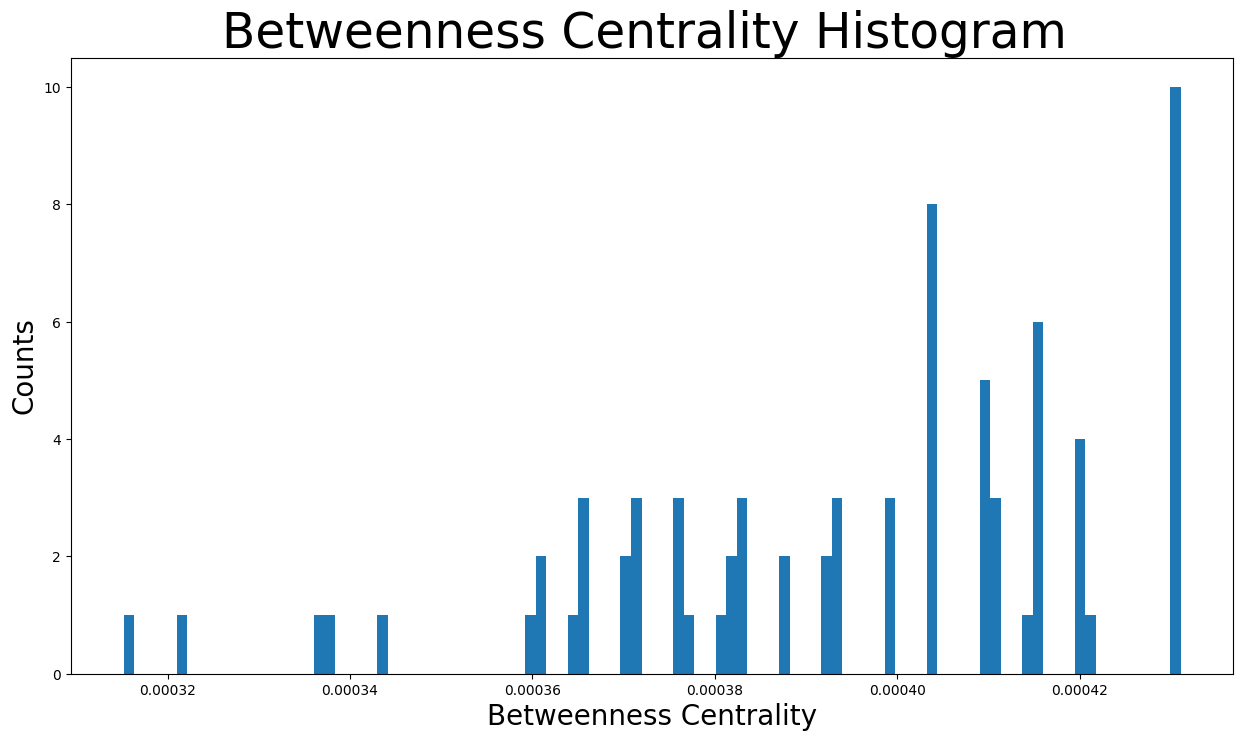

In [15]:
#the graph is very sparse and thus most nodes do not act as bridges in shortest paths
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
#plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1652346683947241,
 1.2057462807071908,
 -1.1504103746601222,
 1.2219056405431155)

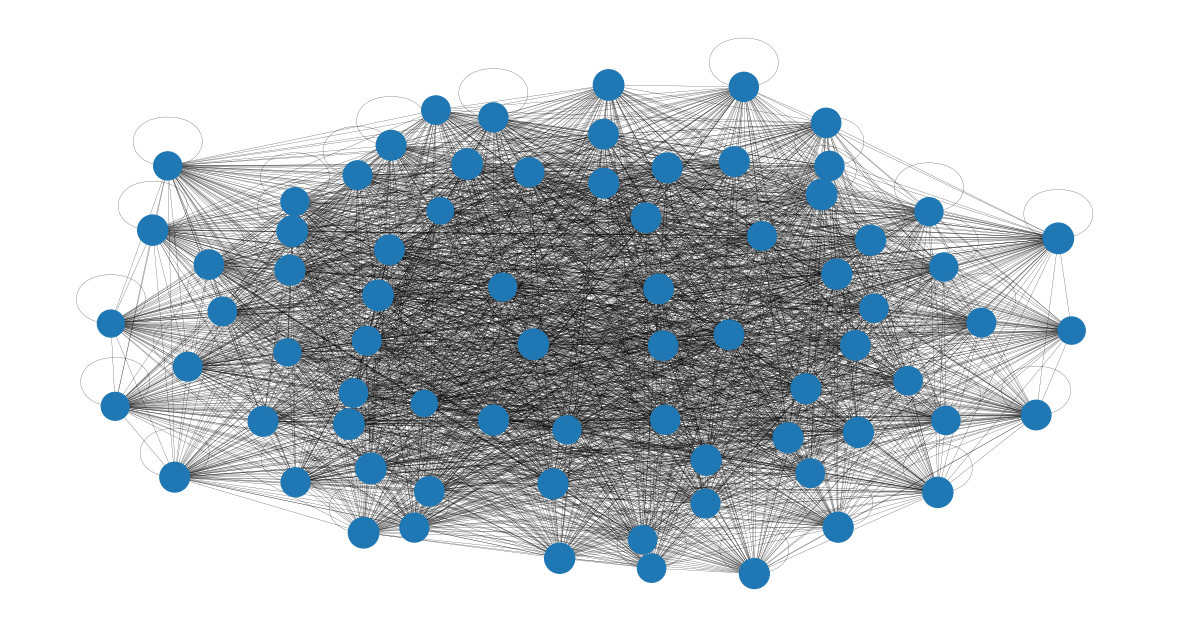

In [16]:
#where are the highest betweenness centralities and where they are located in the network
node_size = [
    v * 1111111 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Closeness Centrality 
Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network. For a node
, its closeness centrality measures the average farness to all other nodes. In other words, the higher the closeness centrality of
, the closer it is located to the center of the network.

Note: The closeness centrality measure is very important for the monitoring of the spread of false information (e.g. fake news) or viruses (e.g. malicious links that gain control of the facebook account in this case). Let’s examine the example of fake news

In [17]:
#Nodes with the highest closeness centralities 
closeness_centrality = nx.centrality.closeness_centrality(
    graph
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

### Note: Avg distinance of a node v to any other node can be found via 1 /  closeness_centrality(v)
## on average the distance from node michal_smith to a random node is 2 hops
1/closeness_centrality['Michael_Smith@wellsfargo.com']

1.027027027027027

Text(0, 0.5, 'Counts')

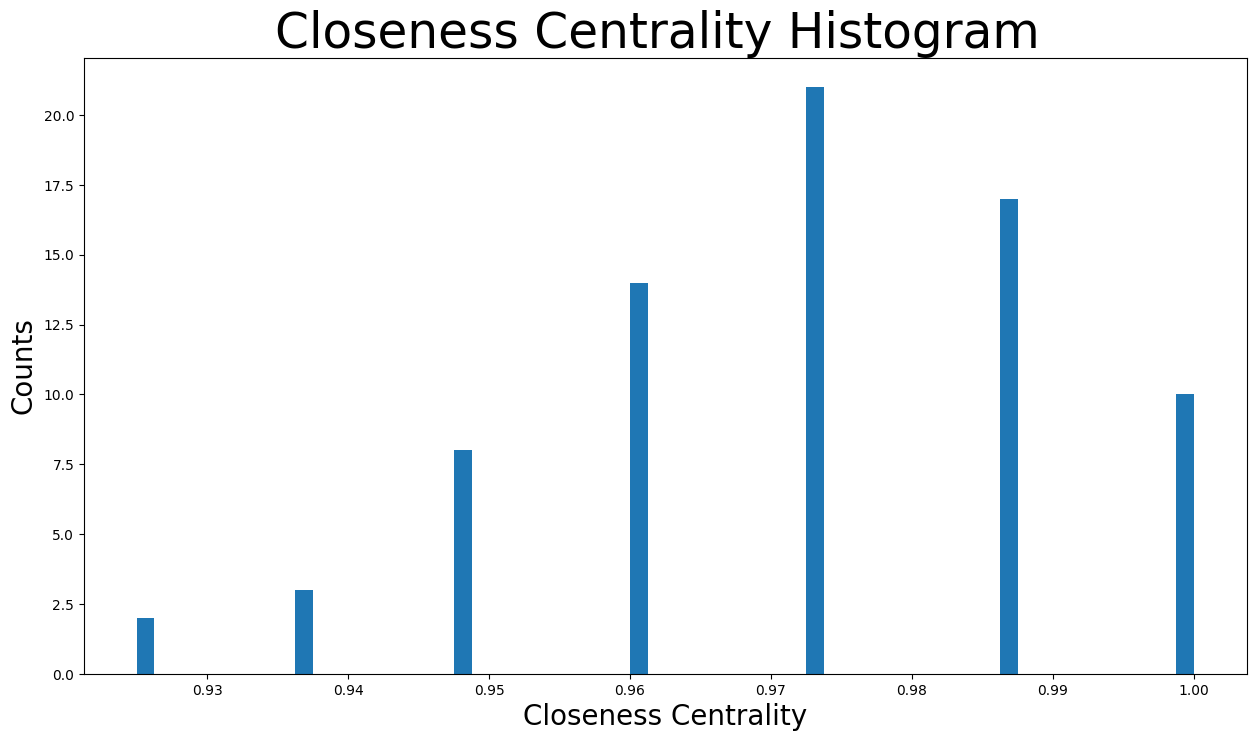

In [18]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1652346683947241,
 1.2057462807071908,
 -1.1504103746601222,
 1.2219056405431155)

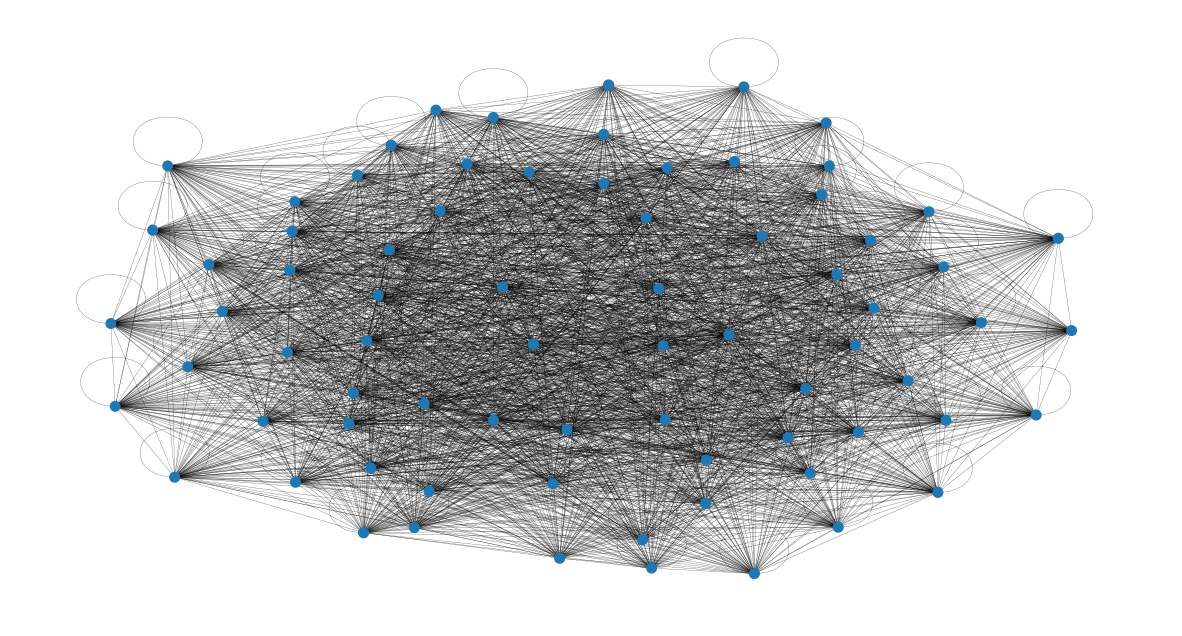

In [19]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Eigenvector Centralit
**Finding the most important nodes in network**
**Eigenvector centrality** is the metric to show how connected a node is to other important nodes in the network. It measures a node’s influence based on how well it is connected inside the network and how many links its connections have and so on. 

**This measure can identify the nodes with the most influence over the whole network.** A high eigenvector centrality means that the node is connected to other nodes who themselves have high eigenvector centralities. The measure is associated with the users ability to influence the whole graph and thus the users with the highest eigenvector centralities are the most important nodes in this network.

In [20]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    graph
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('Michael_Williams@yahoo.com', 0.11905396633659697),
 ('Jane_Smith@wellsfargo.com', 0.11905396633659697),
 ('John_Brown@gmail.com', 0.11905396633659697),
 ('David_Smith@gmail.com', 0.11905396633659697),
 ('John_Brown@yahoo.com', 0.11905396633659697),
 ('Jane_Brown@yahoo.com', 0.11905396633659697),
 ('Michael_Brown@wellsfargo.com', 0.11905396633659697),
 ('Michael_Brown@gmail.com', 0.11905396633659697),
 ('Michael_Johnson@gmail.com', 0.11905396633659697),
 ('Jane_Brown@wellsfargo.com', 0.1175256926027301)]

In [21]:
most_important_node = 'Michael_Smith@yahoo.com'
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2nd to 10th nodes with heighest eigenvector centralities
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]  # set list as [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]



neighbors_1912 = [n for n in graph.neighbors(most_important_node)]  # list with all nodes connected to 1912
all(
    item in neighbors_1912 for item in high_eigenvector_nodes
)  # check if items in list high_eigenvector_nodes exist in list neighbors_1912



True

Text(0, 0.5, 'Counts')

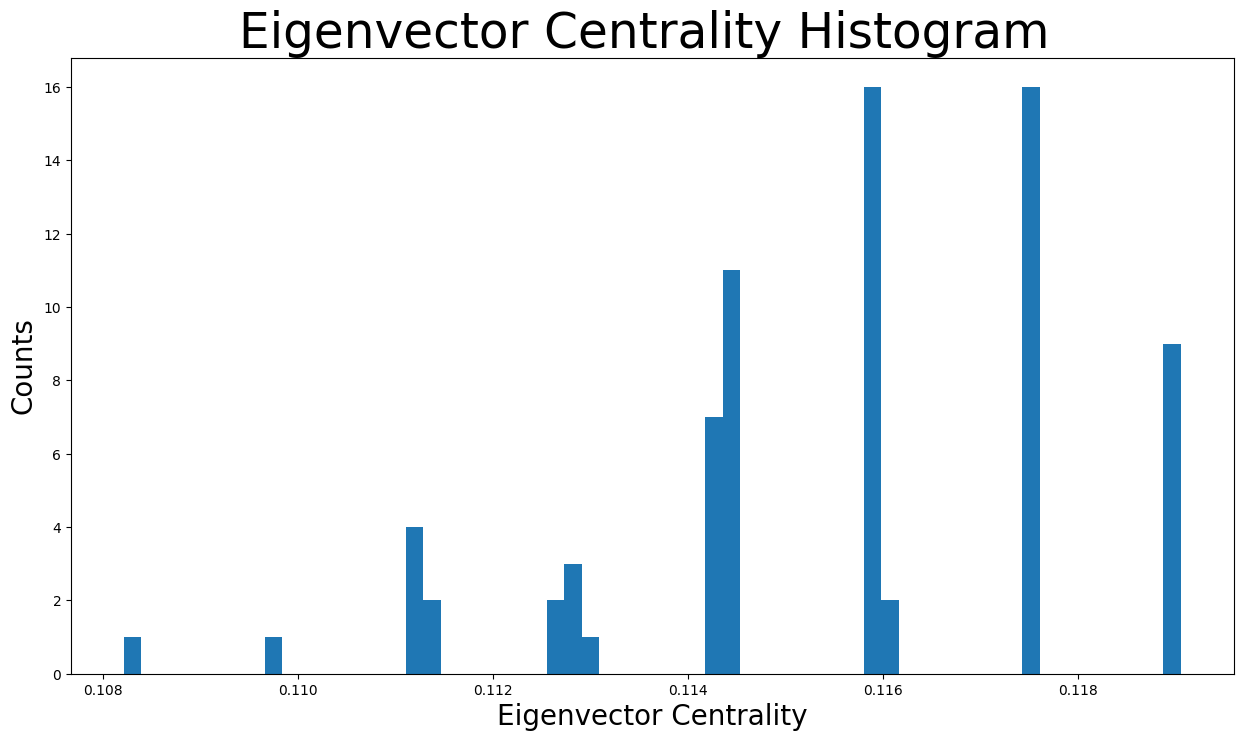

In [22]:
#distribution of the eigenvector centralities:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
#plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1652346683947241,
 1.2057462807071908,
 -1.1504103746601222,
 1.2219056405431155)

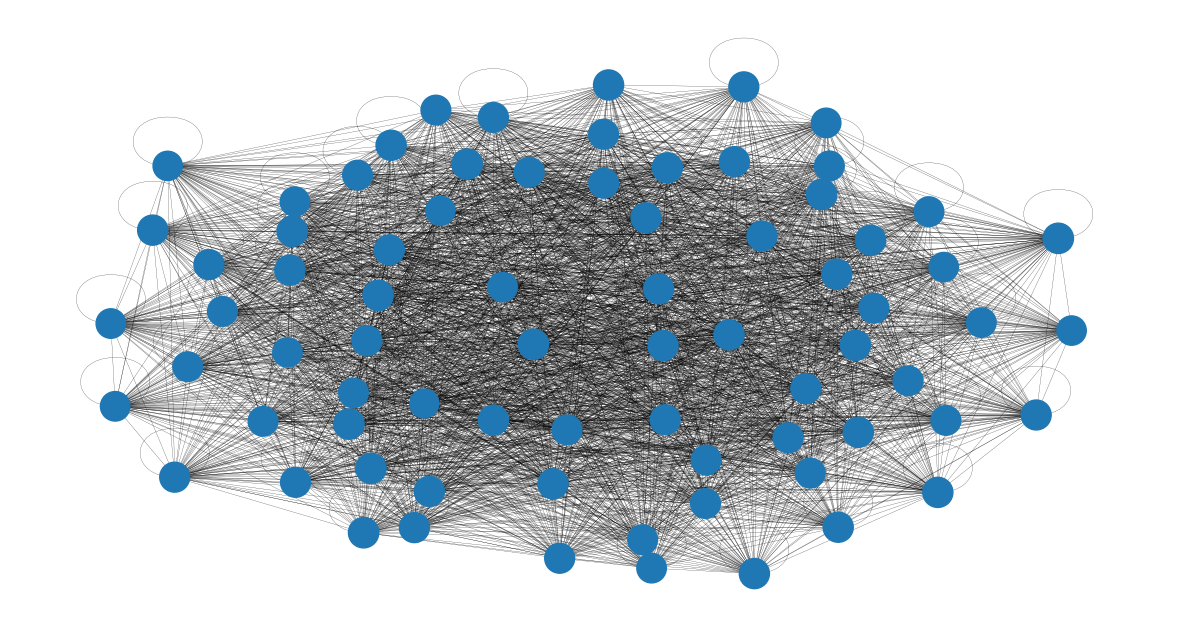

In [23]:
#identify the eigenvector centralities of nodes based on their size in the following representation

# set up nodes size for a nice graph representation
node_size = [v * 4000 for v in eigenvector_centrality.values()]
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Clustering Effects
The clustering coefficient of a node
is defined as the probability that two randomly selected friends of
are friends with each other. As a result, the average clustering coefficient is the average of clustering coefficients of all the nodes. The closer the average clustering coefficient is to
, the more complete the graph will be because there’s just one giant component. Lastly, it is a sign of triadic closure because the more complete the graph is, the more triangles will usually arise.

0.971234222882445


Text(0, 0.5, 'Counts')

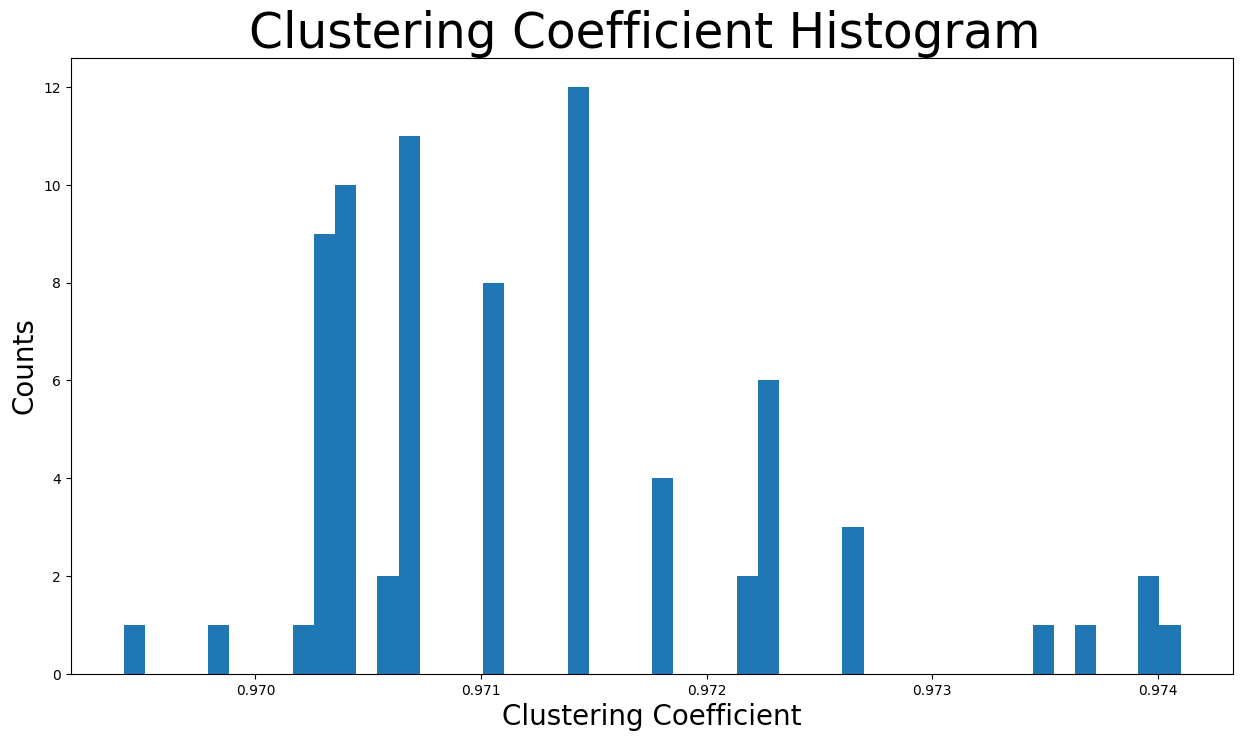

In [24]:
print(nx.average_clustering(graph))

plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(graph).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

#The bin with the highest counts concerns nodes with clustering coefficient close to 1
#as there are more than 6 nodes in that bin. In addition, the bins of clustering coefficient between .966 -.968
#contain the majority of nodes.

#### **Triadic closure:** tendency of nodes in a network to form triangles or clusters.
- number of triangles per node indiciates triadic closure in a network
- a triangle is formed when three nodes are connected to each other. 
- Triadic closure suggests that if two nodes in a network have a common neighbor, there is a higher likelihood that they will form a connection between themselves as well.

- helps understand the formation of clusters or communities within a network. Nodes that are part of the same cluster tend to have more connections with each other, forming triangles and exhibiting a higher degree of triadic closure.

- By analyzing the triadic closure in a network, we can gain insights into the structure and organization of the network. It can help us identify cohesive groups of nodes, detect communities, and understand the overall connectivity patterns within the network



**Conclusion:** A high average clustering coefficient together with a large number of triangles are signs of the triadic closure. In detail, the triadic closure means that as time goes on, new edges tend to form between two users that have one or more mutual edges.

In [25]:
triangles_per_node = list(nx.triangles(graph).values())
sum(
    triangles_per_node
) / 3  # divide by 3 because each triangle is counted once for each node

#avg number of triagnles that a node is a part of 
print(f"mean triangles per cluster node: {np.mean(triangles_per_node)}")

#some nodes that belong to a great many triangles, so median will give us a better understanding:
print(f"meadian triangles per cluster node: {np.median(triangles_per_node)}")

mean triangles per cluster node: 2474.2
meadian triangles per cluster node: 2482.0


### Bridges 
*an edge joining two nodes A and B in the graph is considered a bridge, if deleting the edge would cause A and B to lie in two different components.*


- edges that are bridges will be saved in a list and the number of them is printed
- The existence of so many bridges some nodes are only connected to a single node, making that edge a bridge.


an edge joining two nodes in a graph is a local bridge, if its endpoints have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [26]:
#does the network have bridges 
if nx.has_bridges(graph):

    bridges = list(nx.bridges(graph))
    print(f"trotal bridges:{bridges}")

    local_bridges = list(nx.local_bridges(graph, with_span=False))
    len(local_bridges)

    # Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the 
    # local bridges with the green color. Black edges are neither local bridges nor bridges.
    # It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of
    plt.figure(figsize=(15, 8))
    nx.draw_networkx(graph, pos=pos, node_size=10, with_labels=False, width=0.15)
    nx.draw_networkx_edges(
        graph, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
    )  # green color for local bridges
    nx.draw_networkx_edges(
        graph, pos, edgelist=bridges, width=0.5, edge_color="r"
    )  # red color for bridges
    plt.axis("off")

### Assortativity 
   - The assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes*describes the preference for a networks nodes to attache to others that are similar in some way*
      - a **positive(+)** assortativity coefficient indicates a correlation between nodes of similar degree
      - a **negative(-)** indicates correlation between nodes of different degrees.




**WARNING:** if the assortativity coefficient is around 0, the network is almost non-assortative, and we cannot correlate linked nodes based on their degrees
   - *In terms of social networking , this means we cannot draw conclusions on the number of friends of a user from his/her friends’ number of friends (friends degree)*

In [27]:
#The assortativity in terms of nodes degrees is found with two ways:
#traditional function to calculate assortativity 
nx.degree_assortativity_coefficient(graph)

# use the potentially faster scipy.stats.pearsonr function.
nx.degree_pearson_correlation_coefficient(graph)

-0.018256345602916543

### Network Communities

A community is a group of nodes, so that nodes inside the group are connected with many more edges than between groups.

##### Two diffent algorithms are illistrated for community detection (but many more exist)
1) a semi-synchronous label propagation method is used to detect the communities.
2) the asynchronous fluid communities algorithm is used.here, we can decide the number of communities to be detected. 

In [34]:
from random import randint 
# Now you can use the graph object for network analysis tasks with NetworkX
graph_int = nx.convert_node_labels_to_integers(graph)

colors = ["" for x in range(graph_int.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(graph_int):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter


1

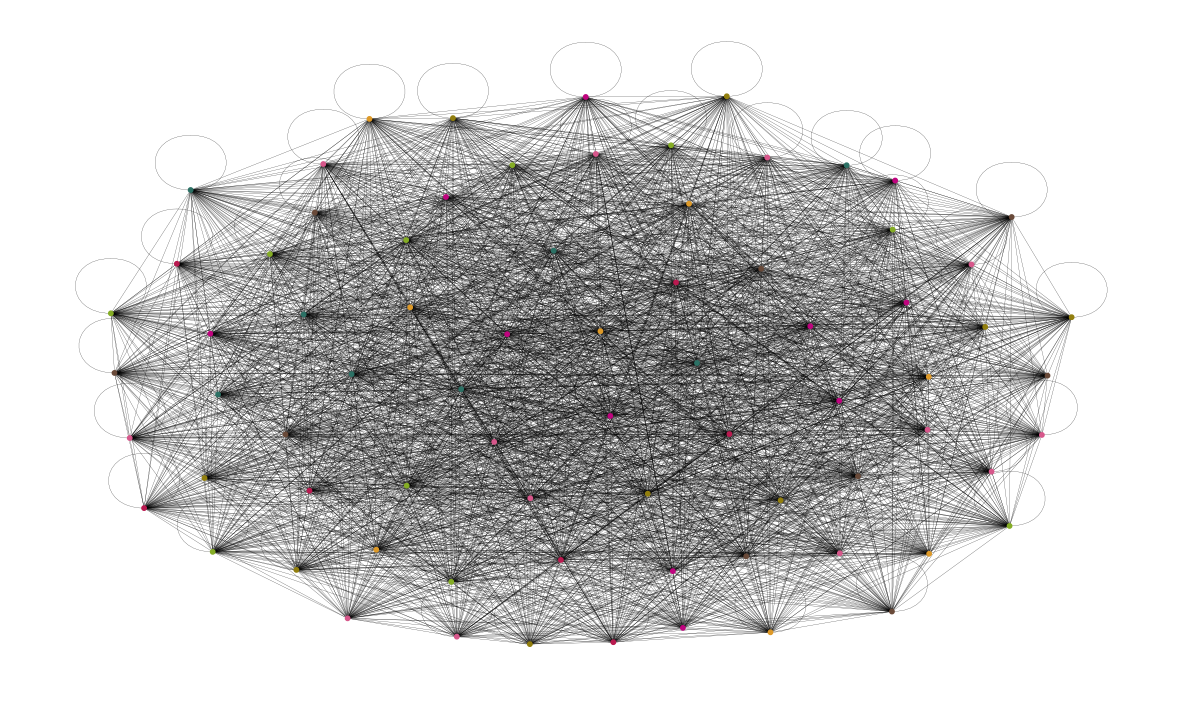

In [39]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    graph_int
    #, pos=pos
    , node_size=10, with_labels=False, width=0.15, node_color=colors
)

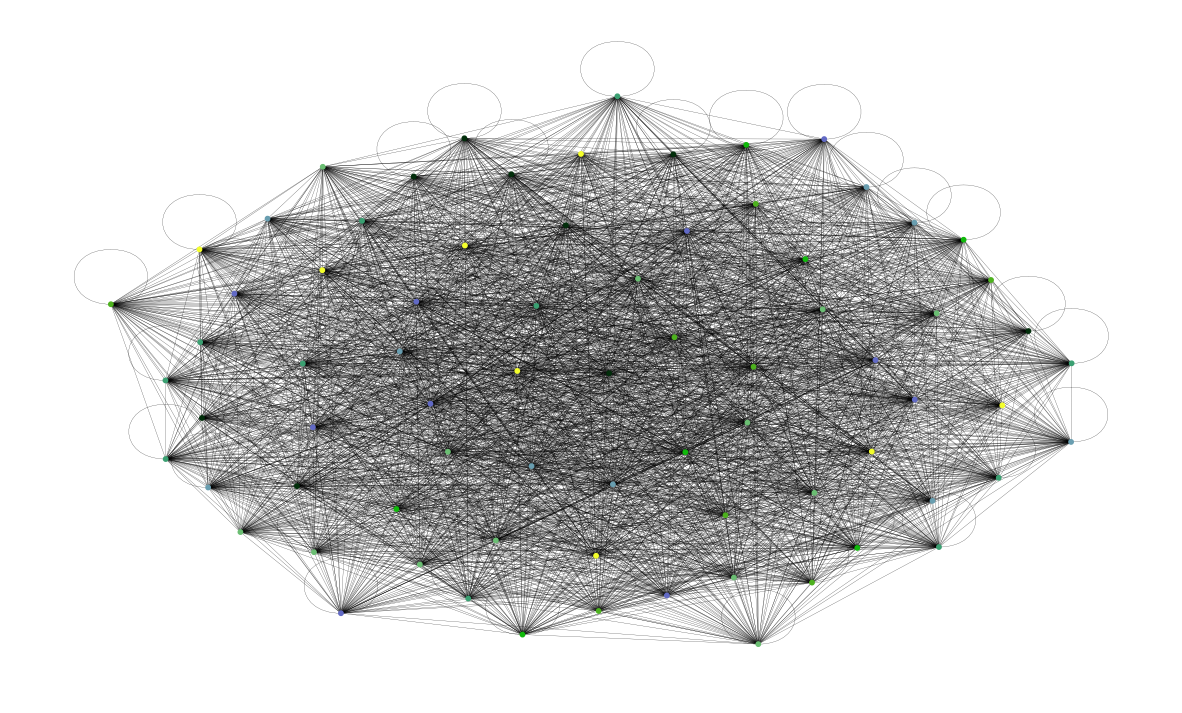

In [41]:
colors = ["" for x in range(graph_int.number_of_nodes())]
for com in nx.community.asyn_fluidc(graph_int, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color


plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    graph_int
    #, pos=pos
    , node_size=10, with_labels=False, width=0.15, node_color=colors
)

### Braedths-First Search(BFS)
- Breadth-first search is a graph traversal algorithm that visits all the vertices of a graph in breadth-first order. 
It starts at the root node and visits all the nodes at the same level before moving on to the next level.

In NetworkX, we can perform a BFS using the bfs_tree() function. This function returns a BFS tree rooted at the specified node.

['Michael_Williams@yahoo.com', 'Emily_Brown@wellsfargo.com', 'Jane_Brown@wellsfargo.com', 'John_Johnson@wellsfargo.com', 'David_Brown@gmail.com', 'David_Jones@yahoo.com', 'Emily_Williams@gmail.com', 'John_Smith@gmail.com', 'John_Williams@gmail.com', 'John_Johnson@yahoo.com', 'Michael_Williams@gmail.com', 'Jane_Williams@wellsfargo.com', 'Emily_Brown@gmail.com', 'Jane_Brown@yahoo.com', 'David_Brown@wellsfargo.com', 'David_Williams@wellsfargo.com', 'John_Williams@wellsfargo.com', 'David_Johnson@yahoo.com', 'Emily_Johnson@wellsfargo.com', 'David_Johnson@gmail.com', 'Jane_Smith@yahoo.com', 'Jane_Johnson@yahoo.com', 'John_Smith@yahoo.com', 'Emily_Jones@gmail.com', 'Emily_Johnson@yahoo.com', 'Jane_Williams@gmail.com', 'David_Johnson@wellsfargo.com', 'John_Jones@gmail.com', 'Jane_Jones@wellsfargo.com', 'Emily_Brown@yahoo.com', 'John_Brown@yahoo.com', 'Jane_Jones@gmail.com', 'Michael_Johnson@yahoo.com', 'Michael_Smith@wellsfargo.com', 'David_Smith@yahoo.com', 'John_Smith@wellsfargo.com', 'David

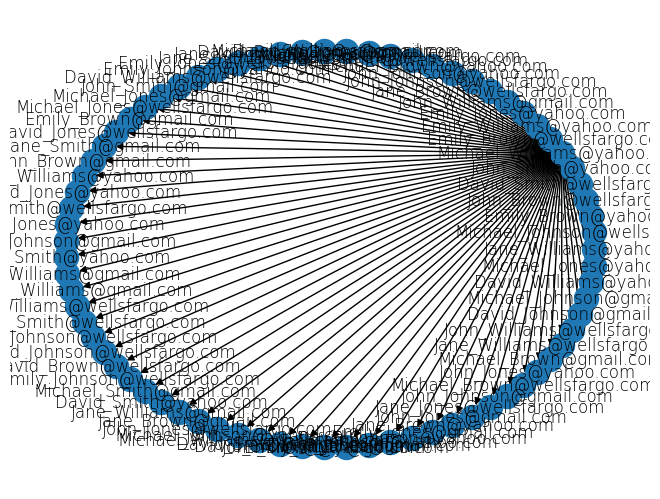

In [58]:
bfs_node = 'Michael_Williams@yahoo.com'
# perform a BFS on the graph starting from node 1
bfs_tree = nx.bfs_tree(graph, bfs_node)

# print the nodes in the BFS tree
print(list(bfs_tree.nodes()))

#draw it 
nx.draw(bfs_tree, pos, with_labels=True, font_weight='light')
plt.savefig('bfs_tree.png', dpi=600)
plt.show(bfs_tree)

### Depth First Search(DFS)
Depth-first search is a graph traversal algorithm that visits all the vertices of a graph in depth-first order. It starts at the root node and visits all the nodes along a path as far as possible before backtracking.

['Michael_Williams@yahoo.com', 'Emily_Brown@wellsfargo.com', 'John_Smith@yahoo.com', 'David_Smith@wellsfargo.com', 'John_Johnson@wellsfargo.com', 'John_Johnson@yahoo.com', 'Michael_Smith@gmail.com', 'John_Williams@yahoo.com', 'John_Brown@gmail.com', 'Jane_Williams@yahoo.com', 'Michael_Johnson@wellsfargo.com', 'Emily_Johnson@wellsfargo.com', 'Jane_Brown@gmail.com', 'Michael_Williams@gmail.com', 'Emily_Williams@wellsfargo.com', 'Emily_Smith@wellsfargo.com', 'Emily_Smith@gmail.com', 'John_Jones@gmail.com', 'Emily_Brown@yahoo.com', 'John_Brown@wellsfargo.com', 'Jane_Williams@gmail.com', 'Emily_Johnson@gmail.com', 'Emily_Smith@yahoo.com', 'David_Johnson@yahoo.com', 'Michael_Williams@wellsfargo.com', 'Jane_Johnson@gmail.com', 'Jane_Smith@yahoo.com', 'Jane_Smith@wellsfargo.com', 'Jane_Smith@gmail.com', 'Emily_Jones@gmail.com', 'David_Brown@yahoo.com', 'John_Brown@yahoo.com', 'David_Smith@yahoo.com', 'John_Smith@gmail.com', 'Michael_Jones@gmail.com', 'Michael_Jones@wellsfargo.com', 'Emily_Brow

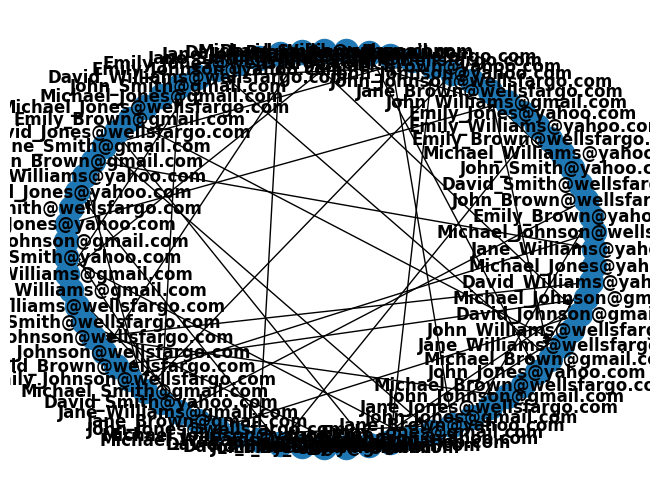

In [59]:
# perform a DFS on the graph starting from node 1
dfs_tree = nx.dfs_tree(graph, bfs_node)

# print the nodes in the DFS tree
print(list(dfs_tree.nodes()))

nx.draw(dfs_tree, pos, with_labels=True, font_weight='bold')
plt.savefig('dfs_tree.png', dpi=600)
plt.show(dfs_tree) 

In [60]:
dfs_tree

### Find the shortest Path between 2 nodes 

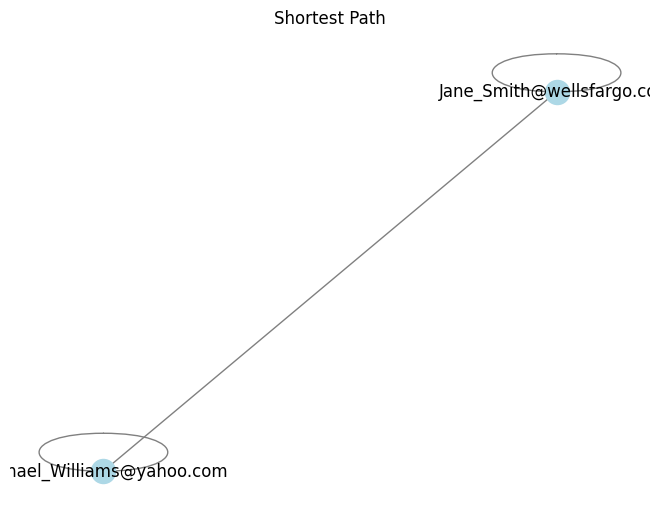

['Michael_Williams@yahoo.com', 'Jane_Smith@wellsfargo.com']


In [61]:
node1 = 'Michael_Williams@yahoo.com'
node2 = 'Jane_Smith@wellsfargo.com'

# find the shortest path between nodes 1 and 7
shortest_path = nx.shortest_path(graph, node1, node2)


# Create a subgraph with only the nodes and edges in the shortest path
subgraph = graph.subgraph(shortest_path)

# Plot the subgraph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Shortest Path')
plt.show()
print(shortest_path) 

### Determing Nth degree of connectivity 

```text
To determine the 2nd degree connectivity between two nodes in a network graph, you can follow these steps:

1. Identify the first-degree neighbors of the starting node.
2. For each first-degree neighbor, identify their first-degree neighbors (excluding the starting node).
3. Check if the target node is among the second-degree neighbors of the starting node.

By performing these steps, you can determine if there is a 2nd degree connectivity between the two nodes in the network graph.
```

In [49]:
node1 = 'Michael_Williams@yahoo.com'
node2 = 'Jane_Smith@wellsfargo.com'

# for pls in shortest_path_lengths.values():
#     print(pls)
#     break


graph






76

# other algorithms (directed only)
- nx.flow.dinitiz
- lowest common ancestor
- euler: https://networkx.org/nx-guides/content/algorithms/euler/euler.html